In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import tslearn
from tslearn.datasets import UCR_UEA_datasets

In [2]:
dataset_name = "ItalyPowerDemand"
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset_name)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(67, 24, 1) (67,) (1029, 24, 1) (1029,)


In [3]:
# -1 from the labels to make them start from 0
y_train -= 1
y_test -= 1

In [4]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
print(X.shape, y.shape)

(1096, 24, 1) (1096,)


In [5]:
#min-max normalization
X = (X - X.min()) / (X.max() - X.min())
print(X.min(), X.max())

0.0 1.0


In [6]:
# torch tensor
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [7]:
#dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


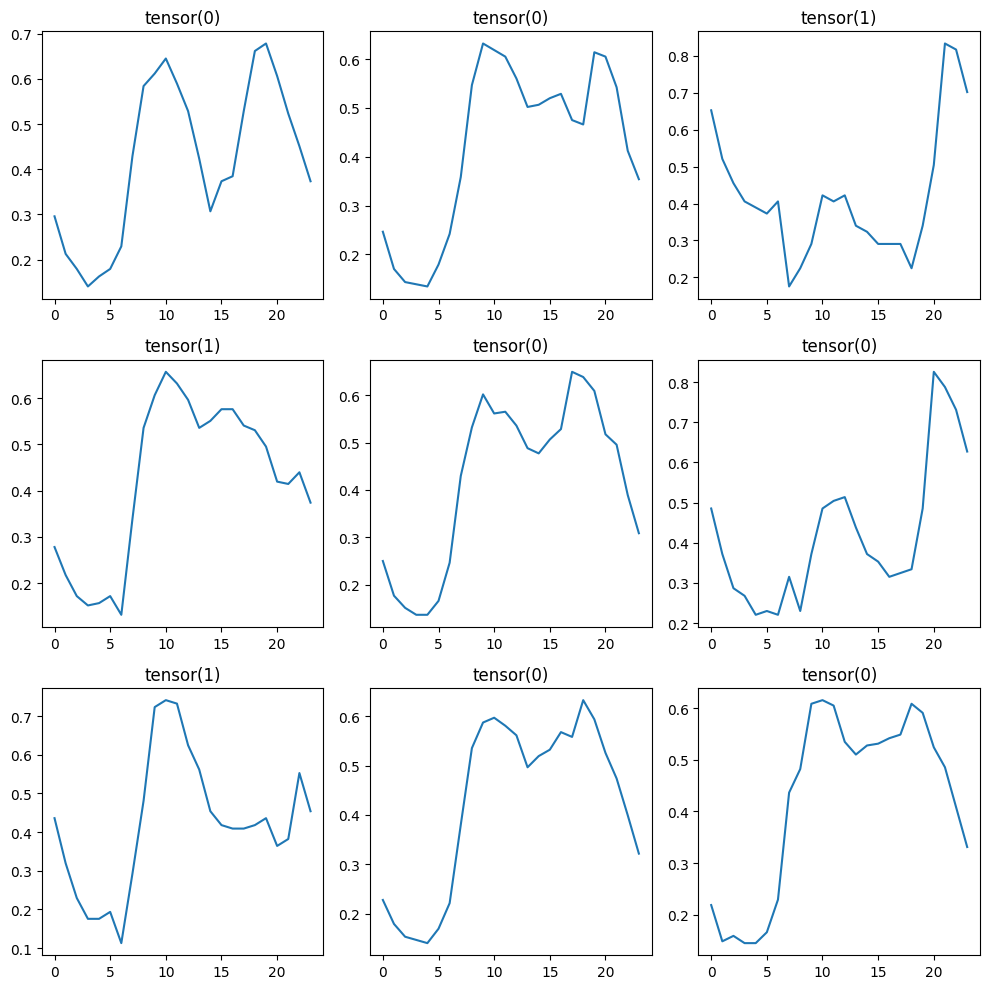

In [9]:
#plto 3x3
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].plot(X[i*3+j, :])
        ax[i, j].set_title(y[i*3+j])
plt.tight_layout()
plt.show()


In [10]:
#lstm generator with class condition
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_class, num_embeddings, num_layers=1):
        super(Generator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(num_class, num_embeddings)
        self.lstm = nn.LSTM(input_size+num_embeddings, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x, c):
        c = c.view(-1, 1).repeat(1, x.size(1))
        c = self.embed(c)
        x = torch.cat((x, c), 2)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

In [11]:
input_size = 1
hidden_size = 32
output_size = 1
num_class = 2
num_embeddings = 1
num_layers = 2
generator = Generator(input_size, hidden_size, output_size, num_class, num_embeddings, num_layers).to(device)
print(generator)

Generator(
  (embed): Embedding(2, 1)
  (lstm): LSTM(2, 32, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
#feed a random noise to generator
noise = torch.randn(32, 24, input_size).to(device)
label = torch.randint(0, num_class, (32,)).to(device)
gen_out = generator(noise, label)
print(gen_out.shape)

torch.Size([32, 24, 1])


In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_class, num_embeddings, num_layers=1):
        super(Discriminator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(num_class, num_embeddings)
        self.lstm = nn.LSTM(input_size+num_embeddings, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, c):
        c = c.view(-1, 1).repeat(1, x.size(1))
        c = self.embed(c)
        x = torch.cat((x, c), 2)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

In [14]:
input_size = 1
hidden_size = 32
output_size = 1
num_class = 2
num_embeddings = 1
num_layers = 1
discriminator = Discriminator(input_size, hidden_size, output_size, num_class, num_embeddings, num_layers).to(device)
print(discriminator)


Discriminator(
  (embed): Embedding(2, 1)
  (lstm): LSTM(2, 32, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [15]:
#feed the generated data to discriminator
disc_out = discriminator(gen_out, label)
print(disc_out.shape)

torch.Size([32, 24, 1])


In [16]:
def random_generator(batch_size, z_dim, max_seq_len, num_class):
    """Random vector generation.

    Args:
    - batch_size: size of the random vector
    - z_dim: dimension of random vector
    - T_mb: time information for the random vector
    - max_seq_len: maximum sequence length

    Returns:
    - Z_mb: generated random vector
    """
    T_mb = list(max_seq_len for i in range(batch_size))
    Z_mb = list()
    for i in range(batch_size):
        temp = np.zeros([max_seq_len, z_dim])
        temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
        temp[:T_mb[i],:] = temp_Z
        Z_mb.append(temp_Z)
    Z_mb = np.array(Z_mb)
    labels = torch.randint(0, num_class, (batch_size, ))
    return torch.tensor(Z_mb).float(), labels.long()

In [17]:
#random noise generation
batch_size = 32
z_dim = 1
max_seq_len = 24
num_class = 2
Z_mb, labels = random_generator(batch_size, z_dim, max_seq_len, num_class)
print(Z_mb.shape, labels.shape)

torch.Size([32, 24, 1]) torch.Size([32])


In [18]:
#loss function and optimizers
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

Epoch [50/1000], d_loss: 0.6613, g_loss: 2.0491


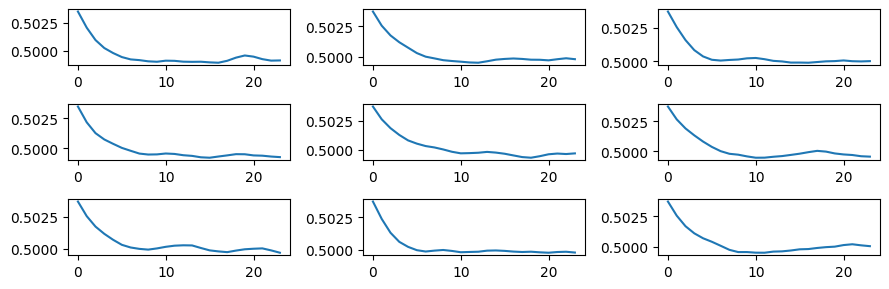

Epoch [100/1000], d_loss: 0.3588, g_loss: 3.7863


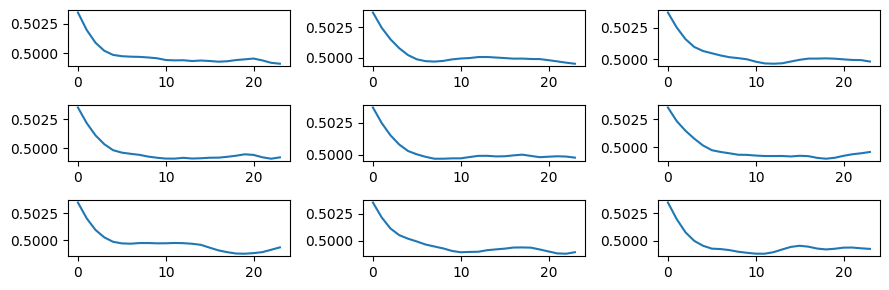

Epoch [150/1000], d_loss: 0.3335, g_loss: 4.7762


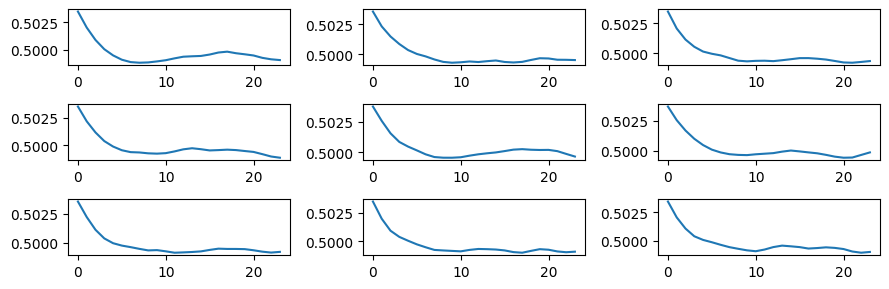

Epoch [200/1000], d_loss: 0.3220, g_loss: 4.3932


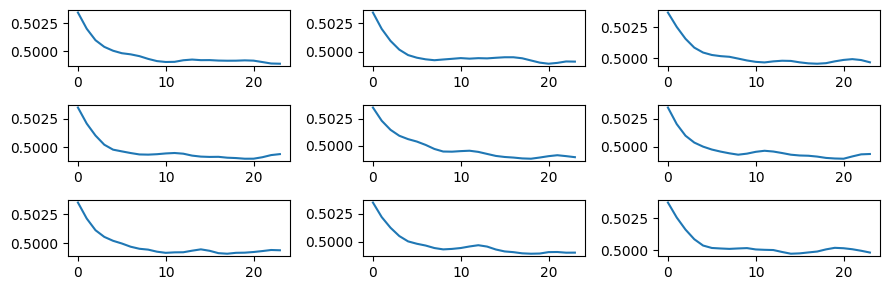

Epoch [250/1000], d_loss: 0.1864, g_loss: 5.2602


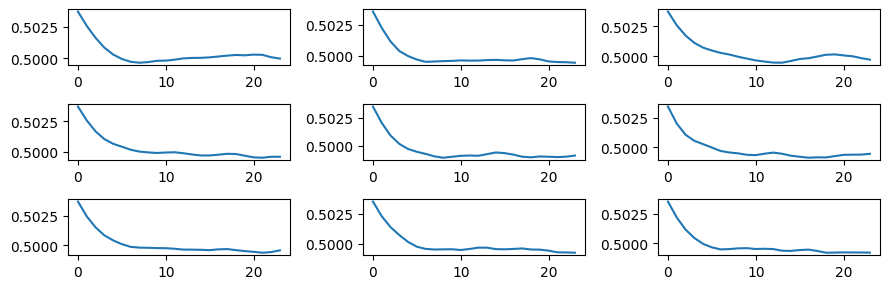

Epoch [300/1000], d_loss: 0.1620, g_loss: 5.3676


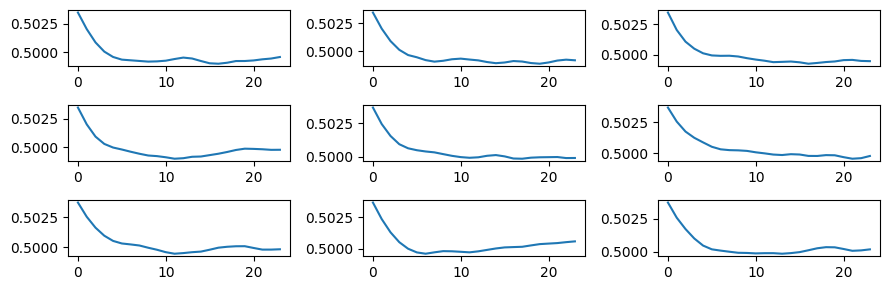

Epoch [350/1000], d_loss: 0.3347, g_loss: 6.4815


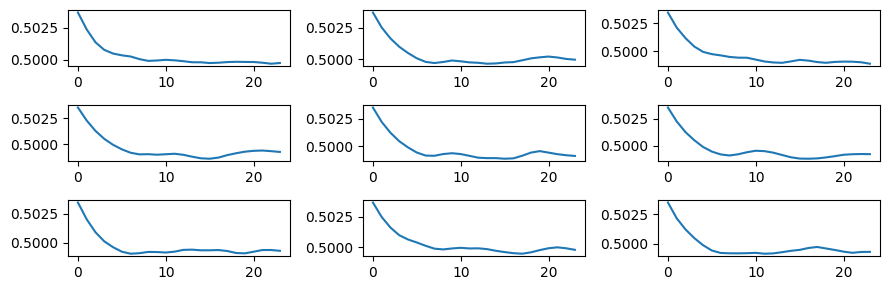

Epoch [400/1000], d_loss: 0.1912, g_loss: 6.5613


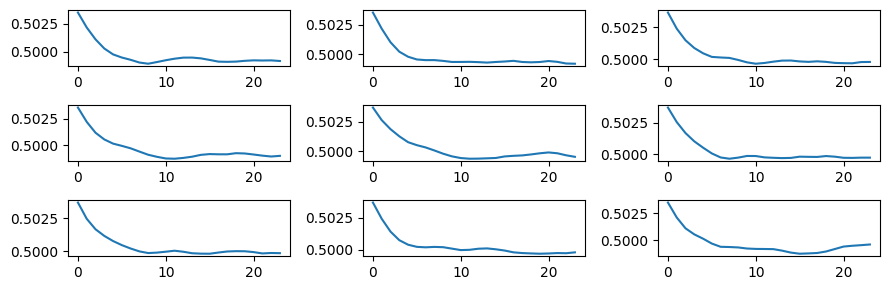

Epoch [450/1000], d_loss: 0.3109, g_loss: 7.2324


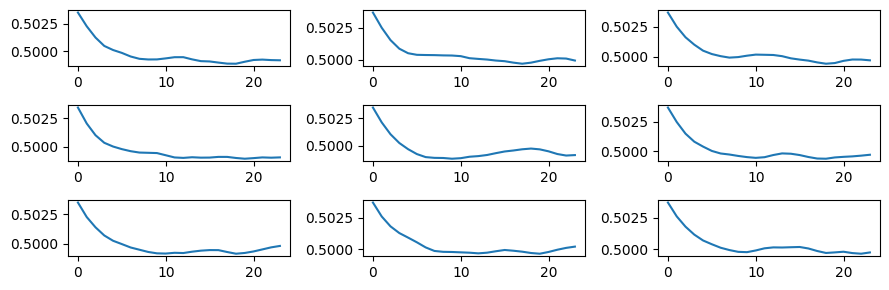

Epoch [500/1000], d_loss: 0.3613, g_loss: 7.3684


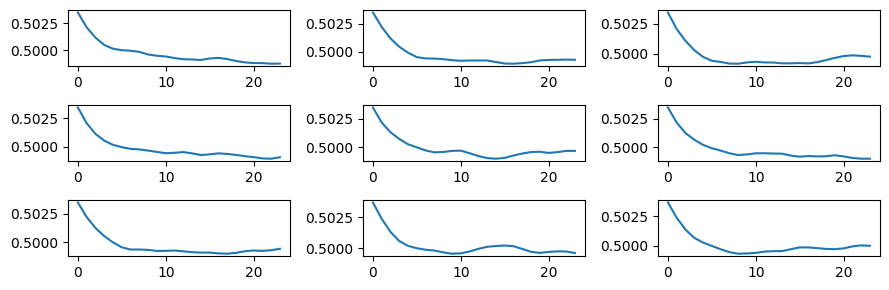

Epoch [550/1000], d_loss: 0.1911, g_loss: 8.7455


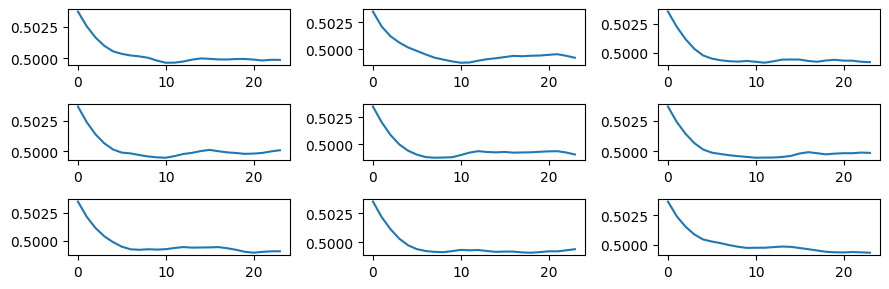

Epoch [600/1000], d_loss: 0.1845, g_loss: 8.7520


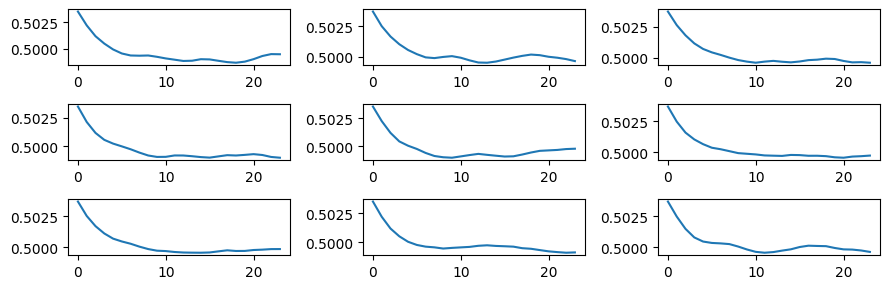

Epoch [650/1000], d_loss: 0.1319, g_loss: 8.1968


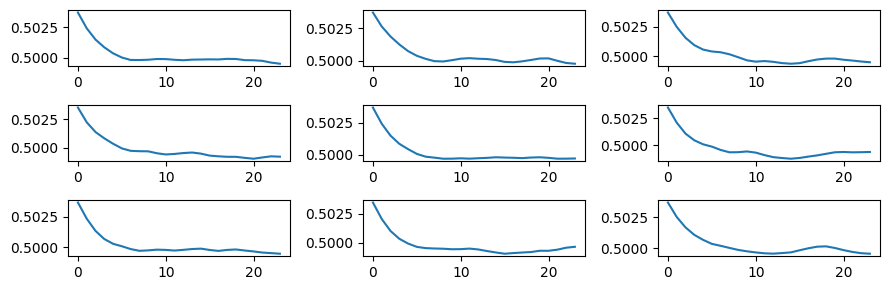

Epoch [700/1000], d_loss: 0.1678, g_loss: 9.1052


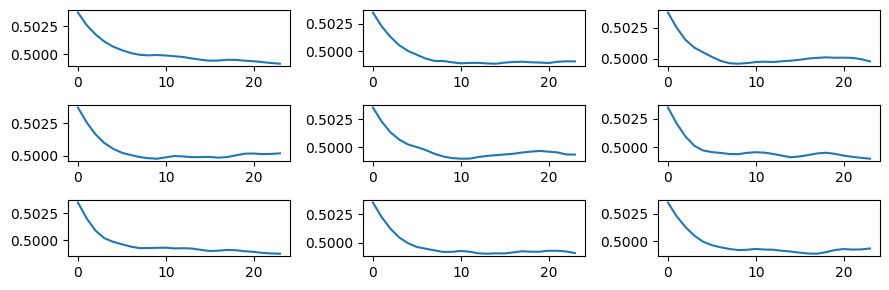

Epoch [750/1000], d_loss: 0.5811, g_loss: 8.4547


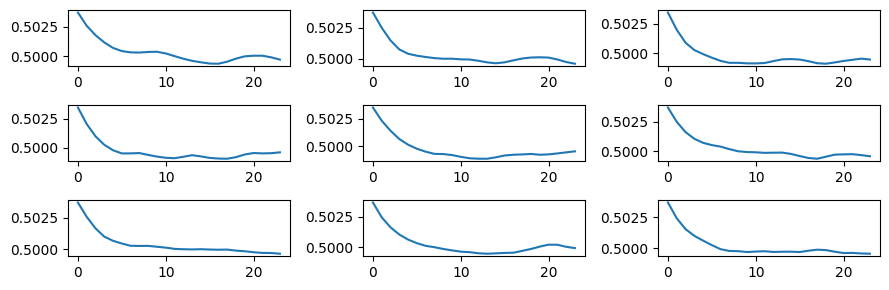

Epoch [800/1000], d_loss: 0.4077, g_loss: 10.0658


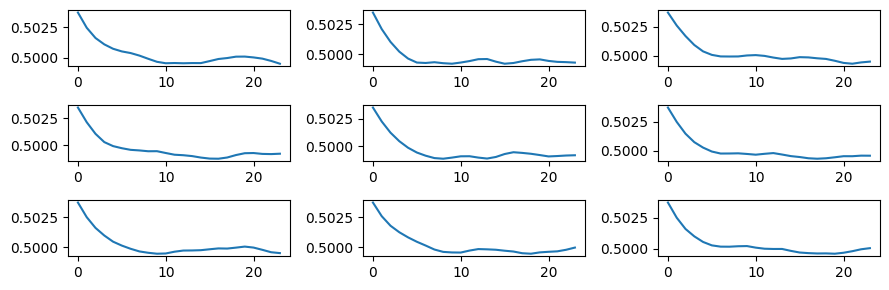

Epoch [850/1000], d_loss: 0.1331, g_loss: 10.3050


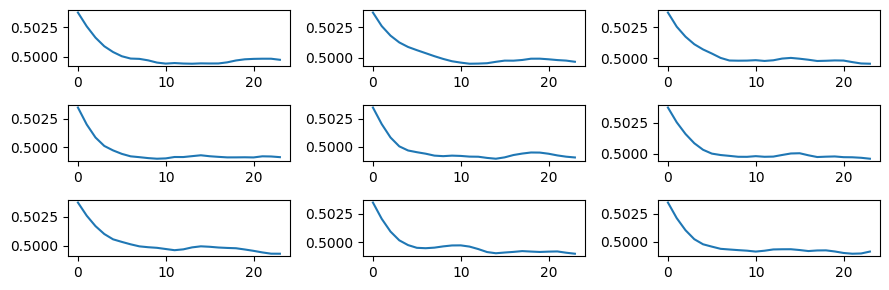

Epoch [900/1000], d_loss: 0.1327, g_loss: 8.7050


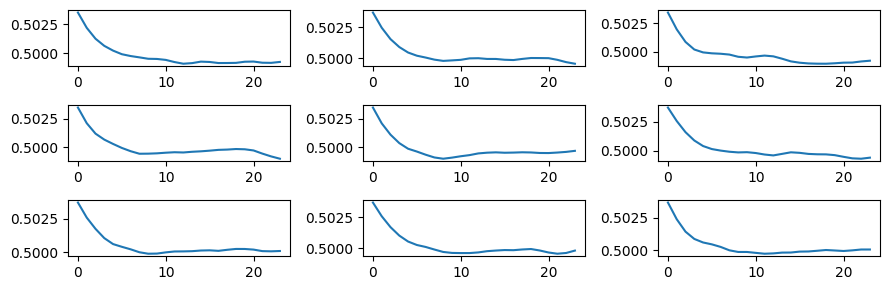

Epoch [950/1000], d_loss: 0.1053, g_loss: 10.9685


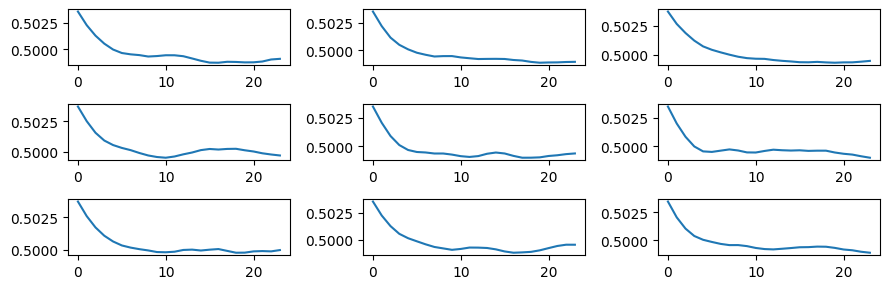

Epoch [1000/1000], d_loss: 0.1658, g_loss: 10.4474


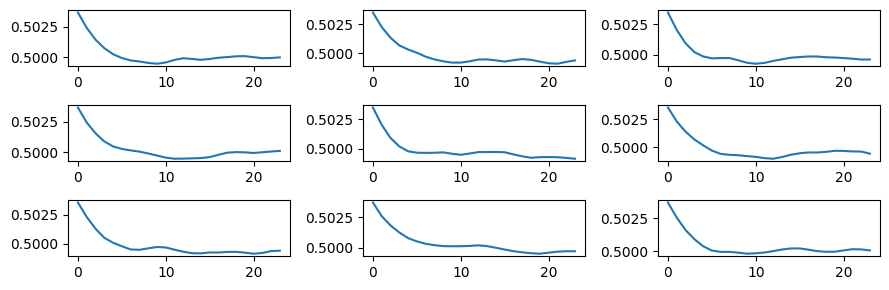

In [19]:
#training
num_epochs = 1000
for epoch in range(num_epochs):
    for data, real_labels in dataloader:
        data = data.to(device)
        real_labels = real_labels.to(device)
        batch_size = data.size(0)
        #train discriminator
        d_optimizer.zero_grad()
        d_real_out = discriminator(data, real_labels)
        d_real_loss = criterion(d_real_out, torch.ones_like(d_real_out))
        Z_mb, fake_labels = random_generator(batch_size, z_dim, max_seq_len, num_class)
        Z_mb = Z_mb.to(device)
        fake_labels = fake_labels.to(device)
        d_fake_out = discriminator(Z_mb, fake_labels)
        d_fake_loss = criterion(d_fake_out, torch.zeros_like(d_fake_out))
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        #train generator
        g_optimizer.zero_grad()
        Z_mb, fake_labels = random_generator(batch_size, z_dim, max_seq_len, num_class)
        Z_mb = Z_mb.to(device)
        fake_labels = fake_labels.to(device)
        g_fake_out = discriminator(Z_mb, fake_labels)
        g_loss = criterion(g_fake_out, torch.ones_like(g_fake_out))
        g_loss.backward()
        g_optimizer.step()
    if (epoch+1)%50 == 0:
        print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))
        #plot the generated data, 3x3 grid
        Z_mb, fake_labels = random_generator(9, z_dim, max_seq_len, num_class)
        Z_mb = Z_mb.to(device)
        fake_labels = fake_labels.to(device)
        gen_out = generator(Z_mb, fake_labels)
        gen_out = gen_out.view(9, 24).cpu().detach().numpy()
        plt.figure(figsize=(9, 3))
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.plot(gen_out[i])
        plt.tight_layout()
        plt.show()

In [ ]:
#generate data
batch_size = 32
z_dim = 1
max_seq_len = 24
num_class = 2
Z_mb, labels = random_generator(batch_size, z_dim, max_seq_len, num_class)
Z_mb = Z_mb.to(device)
labels = labels.to(device)
gen_out = generator(Z_mb, labels)
print(gen_out.shape)

In [ ]:
#plot the generated data, 3x3 grid
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i][j].plot(gen_out[i*3+j].cpu().detach().numpy())
        ax[i][j].set_title('class: {}'.format(labels[i*3+j].item()))
plt.tight_layout()
plt.show()